In [1]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import describe
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Question 1

## CM1

### Q1.1 and Q1.2

In [2]:
df_1 = pd.read_csv("iris_dataset_missing.csv")
df_1.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.045070,2.508203,3.018024,1.164924,Iris-versicolor
1,6.325517,2.115481,4.542052,1.413651,Iris-versicolor
2,5.257497,3.814303,1.470660,0.395348,Iris-setosa
3,6.675168,3.201700,5.785461,2.362764,Iris-virginica
4,5.595237,2.678166,4.077750,1.369266,Iris-versicolor


In [3]:
df_1.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

In [4]:
df_1.shape

(105, 5)

In [5]:
df_1['species'].value_counts()

Iris-virginica     35
Iris-versicolor    35
Iris-setosa        35
Name: species, dtype: int64

In [6]:
df_1.isnull().sum()

sepal_length    0
sepal_width     4
petal_length    8
petal_width     0
species         0
dtype: int64

In [7]:
len(df_1) - len(df_1.dropna())

12

Looking at the scatterplots, I sensed some clusters of classes that may be contributing to Simpson's paradox. Visualizing the plots by the specie type below:

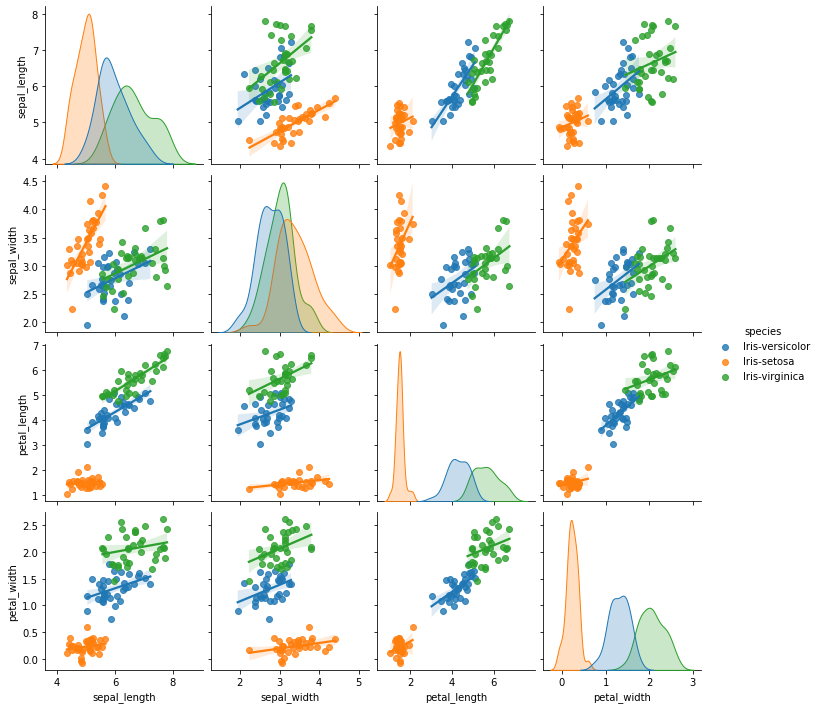

In [8]:
sns.pairplot(df_1, hue='species', kind='reg')

Visually speaking, sepal's length and width seem to be roughly normally distributed whereas, the distribution for petal's length and width appear to be deviating from normality and seem to be showing a bi-modal distribution.

In terms of correlation, all the pairs show interesting patterns.

1. Sepal length vs sepal width:

This looks to be like a perfect example of Simpson's paradox where the correlation seems to be negative "as a whole" but if I look at the correlations of the two apparent clusters, the correlation seems to be positive.

2. Sepal length vs petal width:

This clearly shows an overall positive correlation. We can also see roughly two clusters, the smaller clsuter having a flatter (weak) correlation.

3. Sepal length vs petal length:

Again, this clearly shows an overall positive correlation. We can also see roughly two clusters, the smaller clsuter having a flatter (weak) correlation.

4. Petal width vs petal length:

This clearly shows a strong overall positive correlation. We can also see the two clusters again.

5. Sepal width vs petal length:

This also shows two clusters where the bigger cluster shows a strong positive correlation whereas the smaller one shows a relatively weak correlation.

6. Sepal width vs petal width:

This also seems to be a rough of Simpson's paradox where the overall relationhip differs from the case where we observe correlation in groups. The bigger cluster shows a strong positive correlation whereas the smaller one shows a relatively weak correlation.

## CM2



### Q1.3

In [9]:
pg.pairwise_corr(df_1, method='pearson')[['X', 'Y', 'r', 'p-unc']]

,X,Y,r,p-unc
0,sepal_length,sepal_width,-0.031792,7.523021e-01
1,sepal_length,petal_length,0.880635,1.402514e-32
2,sepal_length,petal_width,0.809915,1.315566e-25
3,sepal_width,petal_length,-0.285793,5.486666e-03
4,sepal_width,petal_width,-0.267574,6.827782e-03
5,petal_length,petal_width,0.958274,1.833107e-53


As can be seen in the plots as well as the pearson correlation co-efficients, there is no significant correlation between sepal's length and width (even at 10% significance level.) However, the rest of the pairs show significant correlations even at 1% significance level.

For the pairs of (sepal_width	petal_length) and (sepal_width	petal_width) specifically, my hypothesis is that the correlation will be even stronger if correlation co-efficients are separately calculated for each of the two clusters.

### Q1.4

In [10]:
desc_1 = df_1.describe()
desc_1.loc['variance'] = df_1.var().tolist()
desc_1.loc['skew'] = df_1.skew().tolist()
desc_1.loc['kurtosis'] = df_1.kurtosis().tolist()
desc_1

,sepal_length,sepal_width,petal_length,petal_width
count,105.000000,101.000000,97.000000,105.000000
mean,5.858909,3.059083,3.812370,1.199708
std,0.861638,0.455116,1.793489,0.787193
min,4.344007,1.946010,1.033031,-0.072203
25%,5.159145,2.768688,1.545136,0.333494
50%,5.736104,3.049459,4.276817,1.331797
75%,6.435413,3.290318,5.094427,1.817211
max,7.795561,4.409565,6.768611,2.603123
variance,0.742420,0.207131,3.216602,0.619672
skew,0.401506,0.367708,-0.255767,-0.074751


### Some observations from these statistics:

1. Both sepal's and petal's length is greater on average as compared to their widths.(Seems logical anyways)
2. Petal's dimensions seem to have a greater spread (variance) as compared to those of sepal's on average.
3. Negative minimum of petal_width indicates noise (outlier).
4. Slightly positive skew of sepal_length and sepal_width indicate distributions skewed to the right whereas negative skew of petal_length and petal_width indicates a distribution skewed to the left. This was evident from the plots above as well.
5. sepal_width has a positive kurtosis indicating heavy-tailed (pointy) distribution whereas negative kurtosis of the rest of the features indicate a relatively platykurtic (flat) distribution. This was evident from the plots as well.

Relationships between features are already explained in detail in Question 1.1 (CM1).

## CM3


### Q1.5

<AxesSubplot:>

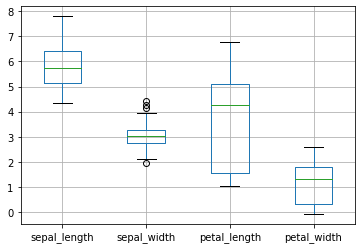

In [11]:
df_1.boxplot()

One way to detect outliers is by means of a boxplot. The boxplot indicates outliers using lower and upper limits that are calculated using Q1 - 1.5 * IQR and Q3 + 1.5 * IQR respectively, where IQR = inter-quartile range = Q3 - Q1.

In the boxplot sepal_width seems to be having values greatly differing from the overall distribution, however, I choose not to remove those datapoints as they may indicate iris plants that are new or have grown quite significantly. These datapoints don't necessarily have to be noise or errors.

Furthermore, the petal_width has a negative minimum which is not physically possible, therefore, I will remove all the datapoints that have a petal_width of greater or equal to 0.

In [12]:
df_1_clean = df_1[df_1['petal_width'] > 0]
len(df_1) - len(df_1_clean)

2

## CM4



### Q1.6

In [13]:
# Heart Disease Only

## CM5



### Q7

In [14]:
print(df_1_clean[df_1_clean.isnull().sum(axis=1) == 1])

    sepal_length  sepal_width  petal_length  petal_width          species
7       5.205868          NaN      1.675654     0.112269      Iris-setosa
21      6.365979          NaN      4.964905     1.817211   Iris-virginica
30      5.673096     4.409565           NaN     0.370518      Iris-setosa
32      5.847160     2.743619           NaN     0.748681  Iris-versicolor
37      6.271780     2.521065           NaN     1.896626   Iris-virginica
39      5.040516     3.466344           NaN     0.314548      Iris-setosa
41      4.496342     3.098270           NaN     0.242853      Iris-setosa
50      5.817283     2.633800           NaN     1.141347  Iris-versicolor
54      6.265590          NaN      4.701306     1.290187  Iris-versicolor
64      6.340344          NaN      4.302989     1.331797  Iris-versicolor
65      6.235536     3.425253           NaN     2.423053   Iris-virginica
85      5.911822     2.560512           NaN     1.766513   Iris-virginica


Since the data is cross-sectional (not time series), it does not make sense to use padding, interpolation or averaging techniques to fill the missing values. So we are left with only two options; fill with mean or drop the rows. Since our dataset is not huge, I would prefer to fill them with their respective means.

In [15]:
df_1_clean['sepal_width'].fillna(df_1_clean['sepal_width'].mean(), inplace=True)
df_1_clean['petal_length'].fillna(df_1_clean['petal_length'].mean(), inplace=True)
df_1_clean['petal_width'].fillna(df_1_clean['petal_width'].mean(), inplace=True)

# Q2

### Q2.1

In [16]:
# Splitting the data
X_train_valid_1, X_test_1, y_train_valid_1, y_test_1 = train_test_split(df_1_clean.drop(columns=['species']),
                                                                df_1_clean['species'],
                                                                test_size = 0.2,
                                                                random_state=275)

X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_valid_1,
                                                      y_train_valid_1,
                                                      test_size = 0.2/(1-0.2),
                                                      random_state=275)

In [17]:
# Confirming that the split is in correct proportions
print(df_1_clean.shape)
for x in [X_train_valid_1, X_test_1, y_train_valid_1, y_test_1, X_train_1, X_valid_1, y_train_1, y_valid_1]:
    print(x.shape)

(103, 5)
(82, 4)
(21, 4)
(82,)
(21,)
(61, 4)
(21, 4)
(61,)
(21,)


### Q2.2

In [18]:
# Building a basic model

knn_1 = KNeighborsClassifier()
knn_1.fit(X_train_1, y_train_1)
score_1 = knn_1.score(X_test_1, y_test_1)
score_1

0.8095238095238095

## CM6

### Q2.3

> ### Note: Based on my piazza discussion with the TA, I am using k-fold cross-validation instead of hold-out method. Although as can be seen, I also implemented the exact holdout method of 60/20/20. I them, extended my find_optimal_k() function so that it accepts different methods as an argument.

> ### All the following analysis is based on 5-fold cross validation in which test set is separated with the same ratio of 20% wheras, during cross-validation, 5 splits of the training+validation set is made and an accuracy is measured. This is repeated 5 times and then the average accuracy is taken. This whole process is repeated for different values of the hyperparamter k.

1.0 0.8571428571428571 0.9279411764705883


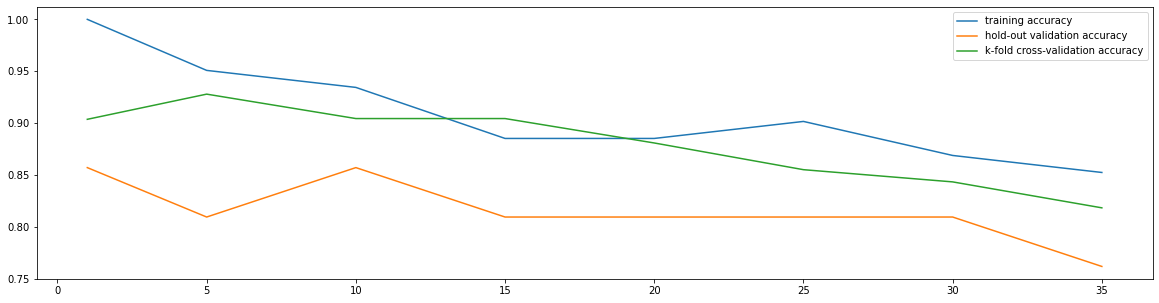

In [19]:
# Tuning the hyperparameter

def find_optimal_k(k_list_1, X_train_1, y_train_1, X_valid_1=None, y_valid_1=None, weights=None, p=2, method="hold-out"):
  
  if method=='hold-out':
    valid_accuracy_1 = []
    training_accuracy_1 = []

    for k in k_list_1:
      knn_1 = KNeighborsClassifier(k, weights, p=p)
      knn_1.fit(X_train_1, y_train_1)
      valid_accuracy_1.append(knn_1.score(X_valid_1, y_valid_1))
      training_accuracy_1.append(knn_1.score(X_train_1, y_train_1))
    
    return training_accuracy_1, valid_accuracy_1

  if method=='cross-val':
    cross_val_accuracy_1 = []

    for k in k_list_1:
      knn_1 = KNeighborsClassifier(k, weights, p=p)
      cv_scores = cross_val_score(knn_1, X_train_1, y_train_1, cv=5)
      cross_val_accuracy_1.append(np.mean(cv_scores))

    return cross_val_accuracy_1


k_list_1 = [1, 5, 10, 15, 20, 25, 30, 35]
training_accuracy_1, valid_accuracy_1 = find_optimal_k(k_list_1, X_train_1, y_train_1, X_valid_1, y_valid_1, method="hold-out")
cross_val_accuracy_1 = find_optimal_k(k_list_1, X_train_valid_1, y_train_valid_1, method="cross-val")

print(max(training_accuracy_1), max(valid_accuracy_1), max(cross_val_accuracy_1))

plt.figure(figsize=(20,5))
plt.plot(k_list_1, training_accuracy_1, label='training accuracy')
plt.plot(k_list_1, valid_accuracy_1, label='hold-out validation accuracy')
plt.plot(k_list_1, cross_val_accuracy_1, label='k-fold cross-validation accuracy')

plt.legend()

Based on the single hold-out validation method, the optimal value for k is 1 and 10 which is a very interesting result. For simplicity of the model, I choose k=1 to be the optimal value. This means that if we just classify the test datapoint based on its closest neighbour. Although it sounds counter-intuitive, the KNN models with k=1 are therefore the most complex methods based on the fact that their decision boundaries are more messy and can learn a lot of noise and therefore the trained model will differ vastly if the input data is changed (low bias and high variance).

Therfore, k=10 is taken as the optimal value.

Based on the 5-fold cross-validation method, the highest average accuracy is achieved at k=5.

## CM 7

### Q2.4

In [20]:
knn_1_validated = KNeighborsClassifier(n_neighbors=5)
knn_1_validated.fit(X_train_1, y_train_1)

score_1_validated = knn_1_validated.score(X_test_1, y_test_1)
score_1_validated

0.8095238095238095

In [21]:
predict_df_1 = pd.DataFrame(X_test_1, columns=df_1.drop(columns=['species']).columns)
predict_df_1['predicted_class'] = knn_1_validated.predict(X_test_1)
predict_df_1['true_class'] = y_test_1
predict_df_1

,sepal_length,sepal_width,petal_length,petal_width,predicted_class,true_class
39,5.040516,3.466344,3.861243,0.314548,Iris-versicolor,Iris-setosa
83,5.775350,2.758149,5.036730,2.284996,Iris-virginica,Iris-virginica
8,4.436832,2.867772,1.428415,0.385249,Iris-setosa,Iris-setosa
100,4.874848,3.217348,1.592887,0.123588,Iris-setosa,Iris-setosa
30,5.673096,4.409565,3.861243,0.370518,Iris-versicolor,Iris-setosa
33,5.593303,2.972604,3.707021,1.475423,Iris-versicolor,Iris-versicolor
94,5.743375,2.987622,4.092458,1.460286,Iris-versicolor,Iris-versicolor
78,6.633922,2.865580,5.464554,2.119895,Iris-virginica,Iris-virginica
57,5.736104,2.983231,4.192791,1.210068,Iris-versicolor,Iris-versicolor
85,5.911822,2.560512,3.861243,1.766513,Iris-versicolor,Iris-virginica


In [22]:
knn_1_predict_proba = knn_1_validated.predict_proba(X_test_1)
knn_1_predict_proba

array([[0.2, 0.8, 0. ],
       [0. , 0.2, 0.8],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0.2, 0.8, 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.8, 0.2],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

### Note:

Since the k=1, this means that while calculating probability for a particular class, both the numerator and the denominator would be 1. Hence, the matrix above only shows 1's and 0's.

In [23]:
roc_auc_score(y_test_1, knn_1_predict_proba, average='weighted', multi_class='ovo', labels=None)

0.96875

I am choosing the 'ovo' scheme since 'ovr' is sensitive to class imbalance when the averaga='macro' that does not take class imbalance into account. However, since I am taking average='weighted' so that my AUC-ROC score takes into account any imbalance in the dataset, the choice between 'ovo' and 'ovr' becomes arbitrary.

In [24]:
print(classification_report(y_test_1, predict_df_1['predicted_class']))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.75      0.86         8
Iris-versicolor       0.56      1.00      0.71         5
 Iris-virginica       1.00      0.75      0.86         8

       accuracy                           0.81        21
      macro avg       0.85      0.83      0.81        21
   weighted avg       0.89      0.81      0.82        21



### Q2.5

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_train_1 = X_train_valid_1
y_train_1 = y_train_valid_1

standard_1 = StandardScaler().fit(X_train_1)

print(standard_1.mean_)
print(standard_1.scale_)

X_train_std_1 = standard_1.transform(X_train_1)
X_valid_std_1 = standard_1.transform(X_valid_1)

[5.91915566 3.04859089 3.87817174 1.22713131]
[0.8616402  0.40122585 1.69605286 0.75397328]


In [26]:
norm_1 = MinMaxScaler().fit(X_train_1)
X_train_norm_1 = norm_1.transform(X_train_1)
X_valid_norm_1 = norm_1.transform(X_valid_1)

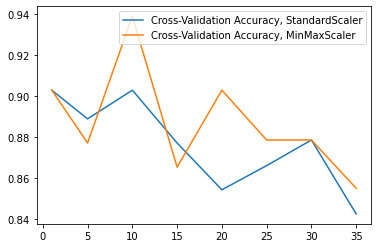

In [27]:
valid_accuracy_std_1 = find_optimal_k(k_list_1, X_train_std_1, y_train_1, X_valid_std_1, y_valid_1, method='cross-val')
valid_accuracy_norm_1 = find_optimal_k(k_list_1, X_train_norm_1, y_train_1, X_valid_norm_1, y_valid_1, method='cross-val')

plt.plot(k_list_1, valid_accuracy_std_1, label='Cross-Validation Accuracy, StandardScaler')
plt.plot(k_list_1, valid_accuracy_norm_1, label='Cross-Validation Accuracy, MinMaxScaler' )

plt.legend()

As can be seen, the min-max scaler gives a better k-fold cross-validation accuracy at k=10 which is as good as k=5 determined previously on un-normalized data.

Practically, there is no hard and fast rule as to when to normalize vs standardize and the best technique has to be found empirically. The goal is to have a single learning rate that works for all the features, irrespective of their scale. For a dataset with many extreme outliers, min-max may not be the best which loses information about the spread of the data. However, our model does not seem to be impact by the few outliers in sepal_width.

Before making any decision, I wait until next question before I decide the optimal set of hyperparameters.

### Q2.6

To further improve the algorithm, weighted-KNN is tried and test below. One way to performance weighted-KNN is by inverse distance kernel function while counting each vote by the K-neighbours i.e 1/(distance) instead of 1.

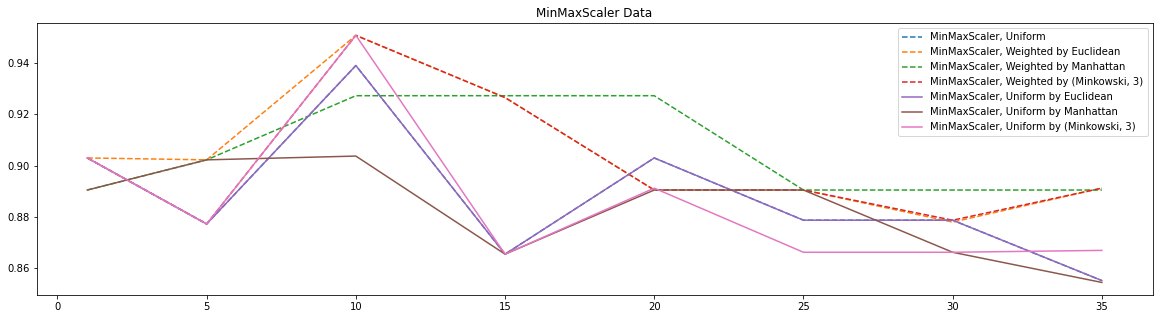

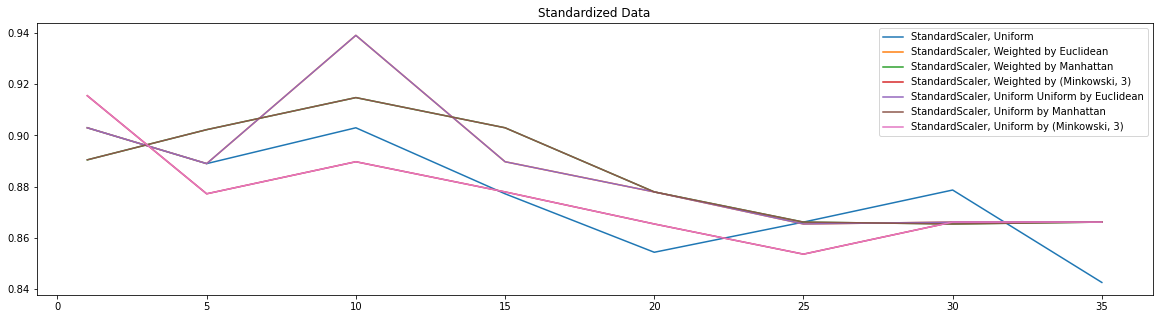

In [28]:
valid_accuracy_norm_weighted_euclidean_1 = find_optimal_k(k_list_1, X_train_norm_1, y_train_1, X_valid_norm_1, y_valid_1, weights='distance', p=2, method='cross-val')
valid_accuracy_norm_weighted_manhattan_1= find_optimal_k(k_list_1, X_train_norm_1, y_train_1, X_valid_norm_1, y_valid_1, weights='distance', p=1, method='cross-val')
valid_accuracy_norm_weighted_3_1 = find_optimal_k(k_list_1, X_train_norm_1, y_train_1, X_valid_norm_1, y_valid_1, weights='distance', p=3, method='cross-val')

valid_accuracy_norm_uniform_euclidean_1 = find_optimal_k(k_list_1, X_train_norm_1, y_train_1, X_valid_norm_1, y_valid_1, weights='uniform', p=2, method='cross-val')
valid_accuracy_norm_uniform_manhattan_1= find_optimal_k(k_list_1, X_train_norm_1, y_train_1, X_valid_norm_1, y_valid_1, weights='uniform', p=1, method='cross-val')
valid_accuracy_norm_uniform_3_1 = find_optimal_k(k_list_1, X_train_norm_1, y_train_1, X_valid_norm_1, y_valid_1, weights='uniform', p=3, method='cross-val')

valid_accuracy_std_weighted_euclidean_1 = find_optimal_k(k_list_1, X_train_std_1, y_train_1, X_valid_std_1, y_valid_1, weights='distance', p=2, method='cross-val')
valid_accuracy_std_weighted_manhattan_1 = find_optimal_k(k_list_1, X_train_std_1, y_train_1, X_valid_std_1, y_valid_1, weights='distance', p=1, method='cross-val')
valid_accuracy_std_weighted_3_1 = find_optimal_k(k_list_1, X_train_std_1, y_train_1, X_valid_std_1, y_valid_1,weights='distance', p=3, method='cross-val')

valid_accuracy_std_uniform_euclidean_1 = find_optimal_k(k_list_1, X_train_std_1, y_train_1, X_valid_std_1, y_valid_1, weights='distance', p=2, method='cross-val')
valid_accuracy_std_uniform_manhattan_1 = find_optimal_k(k_list_1, X_train_std_1, y_train_1, X_valid_std_1, y_valid_1, weights='distance', p=1, method='cross-val')
valid_accuracy_std_uniform_3_1 = find_optimal_k(k_list_1, X_train_std_1, y_train_1, X_valid_std_1, y_valid_1,weights='distance', p=3, method='cross-val')

plt.figure(figsize=(20,5))
plt.plot(k_list_1, valid_accuracy_norm_1, '--', label='MinMaxScaler, Uniform' )
plt.plot(k_list_1, valid_accuracy_norm_weighted_euclidean_1, '--', label='MinMaxScaler, Weighted by Euclidean')
plt.plot(k_list_1, valid_accuracy_norm_weighted_manhattan_1, '--', label='MinMaxScaler, Weighted by Manhattan')
plt.plot(k_list_1, valid_accuracy_norm_weighted_3_1, '--', label='MinMaxScaler, Weighted by (Minkowski, 3)')
plt.plot(k_list_1, valid_accuracy_norm_uniform_euclidean_1, label='MinMaxScaler, Uniform by Euclidean')
plt.plot(k_list_1, valid_accuracy_norm_uniform_manhattan_1, label='MinMaxScaler, Uniform by Manhattan')
plt.plot(k_list_1, valid_accuracy_norm_uniform_3_1, label='MinMaxScaler, Uniform by (Minkowski, 3)')
plt.title("MinMaxScaler Data")
plt.legend()

plt.figure(figsize=(20,5))
plt.plot(k_list_1, valid_accuracy_std_1, label='StandardScaler, Uniform')
plt.plot(k_list_1, valid_accuracy_std_weighted_euclidean_1, label='StandardScaler, Weighted by Euclidean')
plt.plot(k_list_1, valid_accuracy_std_weighted_manhattan_1, label='StandardScaler, Weighted by Manhattan')
plt.plot(k_list_1, valid_accuracy_std_weighted_3_1, label='StandardScaler, Weighted by (Minkowski, 3)')
plt.plot(k_list_1, valid_accuracy_std_uniform_euclidean_1, label='StandardScaler, Uniform Uniform by Euclidean')
plt.plot(k_list_1, valid_accuracy_std_uniform_manhattan_1, label='StandardScaler, Uniform by Manhattan')
plt.plot(k_list_1, valid_accuracy_std_uniform_3_1, label='StandardScaler, Uniform by (Minkowski, 3)')
plt.title("Standardized Data")
plt.legend()

Based on the above graphs, I decide to choose min-max normalizer based on better accuracies. Furthermore, multiple combinations of other hyperparamters such as distance metric and weighting scheme give an even higher maximum score of 95% at k=10. For the sake of simplicity I choose the combination of "Weighted by Euclidean" on the Min-Max scaled data.

The Best Classifier:

In [29]:
best_knn_init_1 = KNeighborsClassifier(n_neighbors=10, weights='distance', p=2)
best_knn_1 = best_knn_init_1.fit(X_train_norm_1, y_train_1)

## CM 7

### Q2.7

In [30]:
X_test_transformed_1 = norm_1.transform(X_test_1)

In [31]:
print("ROC: ", roc_auc_score(y_test_1, best_knn_1.predict_proba(X_test_transformed_1), average='weighted', multi_class='ovo'), "\n\n")
print(classification_report(y_test_1, best_knn_1.predict(X_test_transformed_1)))

ROC:  1.0 


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       0.71      1.00      0.83         5
 Iris-virginica       1.00      0.75      0.86         8

       accuracy                           0.90        21
      macro avg       0.90      0.92      0.90        21
   weighted avg       0.93      0.90      0.91        21



Thus, the model with tuned hyperparamters and normalization gives a much higher accuracy, f1-score and AUC-ROC as compared to the basic model with default parameters.

# Question 3

## CM8

### Q3.1

In machine learning, we evaluate our model on test set to see how our model trained on the training set would perform in the real world. The test set is to be kept hidden from the model for this very purpose. Furthermore, if our model takes some hyperparamters as inputs and we want to fine-tune them for a better out-of-sample accuracy, we will have to experiment with various values of the hyperparamters and evaluate the model's performance. Now, if we evaluate on the test set, this would be cheating. Although our final model may not "directly" see the test set while training, it does see the test set indirectly in the sense that the model developer has seen the performance on that test set and that test set has now contributed to our choice of the hyperparameters. Therefore, we had to have a third set for validation purposes.

### Q3.2

As explained in the previous question as well, the purpose of the test set is to see how our model would behave in the real world, on data that it has never seen before, even "indirectly". If we evaluate model's performance on the test set while tuning the hyperparamters that would be cheating in the sense that the model developer has seen the performance on that test set and that performance on test set has now contributed to our choice of the hyperparameters. Therefore, we had to have a third set for validation purposes.

### Q3.3

The value of k had a varying impact on the model's accuracy. The effect k also varied by our choice of other hyperparameters such as weights and power of the miskowski's distance. This happened because of how KNN algorithm is designed. It calculates distance of a test point with all the points in the training set. It then considers the "k nearest neighbors" based on the calculated distance. It then weights uniformly, or by distance, the votes given by the neighbors and then gives the output. Clearly, the choice of weighting scheme, distance-metric as well as the number of neighbors considered for determining the class would affect the model's accuracy.

# Question 4

> ## Assumming that we have to use the same model as the one we built for previous questions, this time just with different training data.

In [32]:
iris_training = pd.read_csv("iris_train.csv")
iris_test = pd.read_csv("iris_test.csv")

print(iris_training.shape)
print(iris_test.shape)

(105, 5)
(45, 5)


<AxesSubplot:>

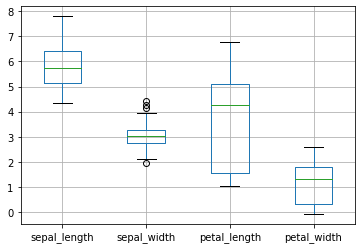

In [33]:
iris_training.boxplot()

<AxesSubplot:>

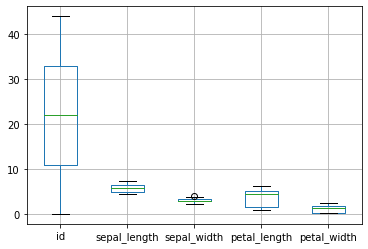

In [34]:
iris_test.boxplot()

In [35]:
iris_training.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,105.000000,101.000000,97.000000,105.000000
mean,5.858909,3.059083,3.812370,1.199708
std,0.861638,0.455116,1.793489,0.787193
min,4.344007,1.946010,1.033031,-0.072203
25%,5.159145,2.768688,1.545136,0.333494
50%,5.736104,3.049459,4.276817,1.331797
75%,6.435413,3.290318,5.094427,1.817211
max,7.795561,4.409565,6.768611,2.603123


In [36]:
iris_test.describe()

,id,sepal_length,sepal_width,petal_length,petal_width
count,45.000000,45.000000,45.000000,45.000000,45.000000
mean,22.000000,5.773333,3.062222,3.695556,1.184444
std,13.133926,0.744800,0.386293,1.738986,0.733595
min,0.000000,4.400000,2.300000,1.000000,0.200000
25%,11.000000,5.000000,2.900000,1.600000,0.300000
50%,22.000000,5.800000,3.000000,4.500000,1.400000
75%,33.000000,6.400000,3.300000,5.100000,1.800000
max,44.000000,7.300000,4.000000,6.300000,2.400000


In [37]:
print(len(iris_training) - len(iris_training.dropna()))
print(len(iris_test) - len(iris_test.dropna()))

12
0


In [38]:
# remove any negative value rows
iris_training = iris_training[iris_training.select_dtypes(include=np.number).ge(0).all(axis=1)]
iris_test = iris_test[iris_test.select_dtypes(include=np.number).ge(0).all(axis=1)]

In [39]:
iris_training['sepal_width'].fillna(iris_training['sepal_width'].mean(), inplace=True)
iris_training['petal_length'].fillna(iris_training['petal_length'].mean(), inplace=True)
iris_training['petal_width'].fillna(iris_training['petal_width'].mean(), inplace=True)

iris_test['sepal_width'].fillna(iris_test['sepal_width'].mean(), inplace=True)
iris_test['petal_length'].fillna(iris_test['petal_length'].mean(), inplace=True)
iris_test['petal_width'].fillna(iris_test['petal_width'].mean(), inplace=True)

print(iris_training.shape)
print(iris_test.shape)

(91, 5)
(45, 5)


In [40]:
iris_training_X = iris_training.drop(columns=['species'])
iris_training_y = iris_training['species']
iris_test_X = iris_test[["sepal_length", "sepal_width",	"petal_length", "petal_width"]]

In [41]:
norm_1 = MinMaxScaler().fit(iris_training_X)
best_knn_1 = best_knn_init_1.fit(norm_1.transform(iris_training_X), iris_training_y)
iris_test_transformed_X = norm_1.transform(iris_test_X)
iris_predict = best_knn_1.predict(iris_test_transformed_X)
iris_predict = pd.DataFrame(iris_predict).reset_index()
iris_predict.columns = ['id', 'species']
iris_predict.head()

,id,species
0,0,Iris-virginica
1,1,Iris-versicolor
2,2,Iris-versicolor
3,3,Iris-versicolor
4,4,Iris-virginica


In [42]:
map_species = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}

In [43]:
iris_predict['species'] = iris_predict['species'].map(map_species)
iris_predict.to_csv("iris_submission_1.csv", index=False)
iris_predict.head()

,id,species
0,0,2
1,1,1
2,2,1
3,3,1
4,4,2
